# Linear Regression in statsmodels (Practice)
---

Author: Jackson Muehlbauer

Date: 3/19/23

In [105]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline

# metrics
from sklearn.metrics import r2_score, mean_squared_error

# statsmodel
import statsmodels.api as sm


In [106]:
# load data
path = 'archive/CarPrice_Assignment.csv'
df = pd.read_csv(path)
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Exploring and Cleaning DataFrame

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

No missing data

In [108]:
df_ob = df.select_dtypes(include = 'object')
df_ob.head()
for col in df_ob.columns:
    print(f'{col} \n {df_ob[col].value_counts()} \n')

CarName 
 toyota corona           6
toyota corolla          6
peugeot 504             6
subaru dl               4
mitsubishi mirage g4    3
                       ..
mazda glc 4             1
mazda rx2 coupe         1
maxda glc deluxe        1
maxda rx3               1
volvo 246               1
Name: CarName, Length: 147, dtype: int64 

fueltype 
 gas       185
diesel     20
Name: fueltype, dtype: int64 

aspiration 
 std      168
turbo     37
Name: aspiration, dtype: int64 

doornumber 
 four    115
two      90
Name: doornumber, dtype: int64 

carbody 
 sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64 

drivewheel 
 fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64 

enginelocation 
 front    202
rear       3
Name: enginelocation, dtype: int64 

enginetype 
 ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64 

cylindernumber 
 four  

CarName won't be particularly useful for modeling

In [109]:
df.duplicated().sum()

0

In [110]:
df['symboling'].value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

No duplicates

## Initial Preprocessing

In [111]:
# validation split
X = df.drop(columns = ['car_ID', 'CarName', 'price']).copy()
y = df['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [112]:
# numeric columns don't need to be processed
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
num_cols = num_selector(X_train) # saving these for later
cat_cols = cat_selector(X_train) # saving these for later


ohe = OneHotEncoder(handle_unknown='ignore')


cat_tup = (ohe, cat_selector)

preprocessor = make_column_transformer(cat_tup, remainder = 'passthrough')


In [113]:
# fit
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x146875100>)])

In [114]:
df_temp = pd.DataFrame(preprocessor.transform(X_train))
df_temp.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,54.5,2017.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,54.9,2326.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,53.5,2024.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,53.1,2507.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,52.0,2540.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0


In [115]:
# get ohe step
ohe_step = preprocessor.named_transformers_['onehotencoder']

In [116]:
# get cat feature names
cat_features = ohe_step.get_feature_names_out(cat_cols)

In [117]:
# final feature list

final_features = []
final_features.extend(cat_features)
final_features.extend(num_cols)
final_features

['fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginelocation_rear',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

In [118]:
# make dataframe with feature names
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns = final_features, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns = final_features, index = X_test.index)
X_train_df.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,54.5,2017.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0
173,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,54.9,2326.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0
93,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,53.5,2024.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0
5,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,53.1,2507.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0
167,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,52.0,2540.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0


In [119]:
## overwrite dfs to have constants
X_train_df = sm.add_constant(X_train_df, prepend = False, has_constant = 'add')
X_test_df = sm.add_constant(X_test_df, prepend = False, has_constant = 'add')
display(X_train_df.head(2), X_test_df.head(2))

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,const
90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2017.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,1.0
173,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2326.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,1.0


,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,const
15,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3230.0,209.0,3.62,3.39,8.0,182.0,5400.0,16.0,22.0,1.0
9,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3053.0,131.0,3.13,3.40,7.0,160.0,5500.0,16.0,22.0,1.0


## OLS statsmodels

In [120]:
# Getting summary
model = sm.OLS(y_train, X_train_df, hasconst = True)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     55.20
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           1.78e-57
Time:                        15:40:04   Log-Likelihood:                -1360.4
No. Observations:                 153   AIC:                             2801.
Df Residuals:                     113   BIC:                             2922.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
fueltype_diesel       -2754.0108   3061.925     -0.899      0.370   -8820.237    3312.215
fueltype_gas          -6762.3873   3036.682     -2.227      0.028   -1.28e+04    -746.173
aspiration_std        -5830.9890   2041.671     -2.856      0.005   -9875.907   -1786.071
aspiration_turbo      -3685.4091   1914.199     -1.925      0.057   -7477.782     106.964
doornumber_four       -4661.2975   1993.045     -2.339      0.021   -8609.880    -712.715
doornumber_two        -4855.1005   1909.915     -2.542      0.012   -8638.988   -1071.214
carbody_convertible     391.1172   1061.363      0.369      0.713   -1711.634    2493.869
carbody_hardtop       -3386.3942   1316.419     -2.572      0.011   -5994.457    -778.331
carbody_hatchback     -2189.8314    996.073     -2.198      0.030   -4163.232    -216.431
carbody_sedan         -1341.0731   1010.567     -1.327      0.187   -3343.190     661.043
carbody_wagon         -2990.2165   1173.725     -2.548      0.012   -5315.577    -664.856
drivewheel_4wd        -3033.9503   1434.421     -2.115      0.037   -5875.797    -192.104
drivewheel_fwd        -3589.9257   1541.345     -2.329      0.022   -6643.609    -536.242
drivewheel_rwd        -2892.5221   1476.047     -1.960      0.053   -5816.837      31.793
enginelocation_front  -9870.6333   2400.932     -4.111      0.000   -1.46e+04   -5113.954
enginelocation_rear     354.2353   2484.564      0.143      0.887   -4568.134    5276.604
enginetype_dohc        -267.6125   1201.258     -0.223      0.824   -2647.522    2112.297
enginetype_dohcv      -6841.5974   4325.556     -1.582      0.117   -1.54e+04    1728.109
enginetype_l          -1209.6804   2051.071     -0.590      0.557   -5273.222    2853.861
enginetype_ohc         1988.0034   1255.997      1.583      0.116    -500.352    4476.359
enginetype_ohcf        -284.2699   1740.709     -0.163      0.871   -3732.929    3164.389
enginetype_ohcv       -5304.6838   1245.289     -4.260      0.000   -7771.825   -2837.542
enginetype_rotor       2403.4425   1519.008      1.582      0.116    -605.986    5412.871
cylindernumber_eight   5132.6433   2153.981      2.383      0.019     865.218    9400.069
cylindernumber_five   -2912.4014   1934.432     -1.506      0.135   -6744.861     920.058
cylindernumber_four   -3951.9226   1889.604     -2.091      0.039   -7695.568    -208.277
cylindernumber_six    -2098.7982   1007.476     -2.083      0.039   -4094.789    -102.808
cylindernumber_twelve -8089.3617   4412.912     -1.833      0.069   -1.68e+04     653.413
cylindernumber_two     2403.4425   1519.008      1.582      0.116    -605.986    5412.871
fuelsystem_1bbl        -657.5227   1072.036     -0.613      0.541   -2781.420    1466.375
fuelsystem_2bbl        -544.6957    830.758     -0.656      0.513   -2190.576    1101.185
fuelsystem_4bbl       -

In [121]:
# evaluate model on test data
test_preds = result.predict(X_test_df)

print(f'Testing r-squared: {r2_score(y_test, test_preds):.3f}')
print(f'Testing RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.3f}')

Testing r-squared: 0.881
Testing RMSE: 2842.345


# Assumptions of Linear Regression

## Assumption of Linearity

In [122]:
# slice the list of numerical features to slice for pairplot
num_selector = make_column_selector(dtype_include = 'number')
cols = num_selector(df.drop(columns = 'price'))
len(cols)


15

In [123]:
# define plot format
plot_kws = dict(line_kws = {'color':'red', 'ls':'--'},
               scatter_kws = {'edgecolor':'white', 'lw':1})

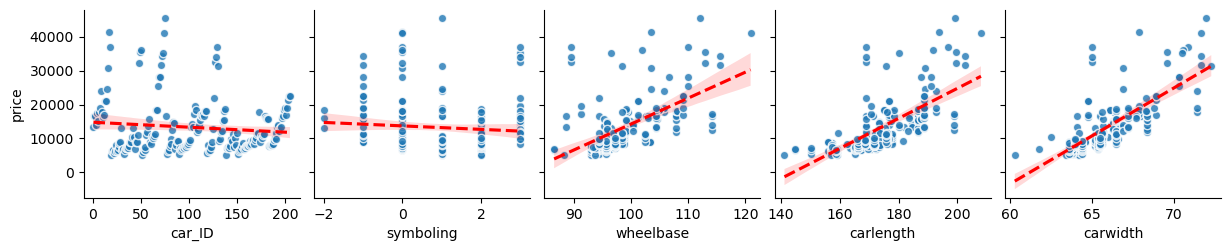

In [124]:
# making pairplot with regression lines
sns.pairplot(data = df, y_vars = 'price', x_vars = cols[:5], kind = 'reg', plot_kws = plot_kws)

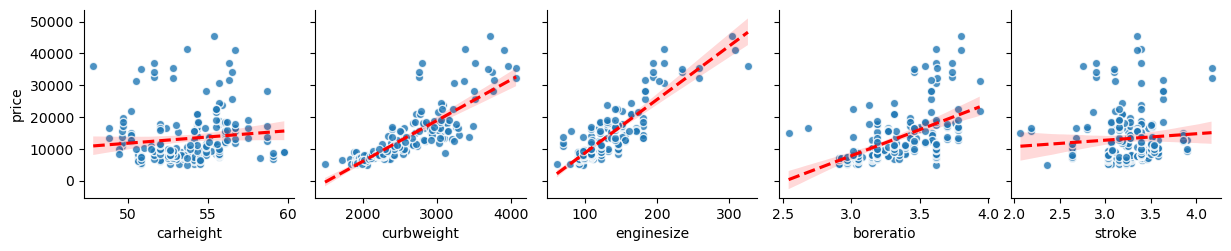

In [125]:
# making pairplot with regression lines
sns.pairplot(data = df, y_vars = 'price', x_vars = cols[5:10], kind = 'reg', plot_kws = plot_kws)

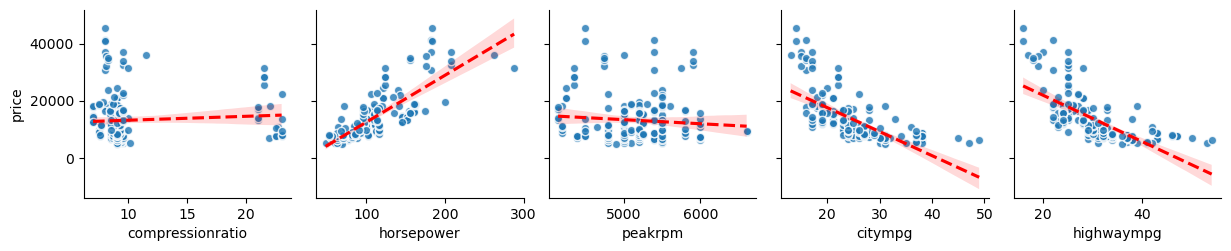

In [126]:
# making pairplot with regression lines
sns.pairplot(data = df, y_vars = 'price', x_vars = cols[10:], kind = 'reg', plot_kws = plot_kws)

**Interpretation:**

car_ID, stroke, and compressionratio do not appear to have linear relation to our target. 

In [127]:
df = df.drop(columns = ['car_ID', 'stroke', 'compressionratio'])
df.columns

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'horsepower', 'peakrpm',
       'citympg', 'highwaympg', 'price'],
      dtype='object')

## Assumption of Little-to-no-multicollinearity

In [128]:
# calc abs values of correlations
corr = df.drop(columns = 'price').corr().abs()
corr

/var/folders/8k/75t3_8pj0v32jr8dhb7x00nw0000gn/T/ipykernel_65617/274696288.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns = 'price').corr().abs()


,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,horsepower,peakrpm,citympg,highwaympg
symboling,1.000000,0.531954,0.357612,0.232919,0.541038,0.227691,0.105790,0.130051,0.070873,0.273606,0.035823,0.034606
wheelbase,0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.353294,0.360469,0.470414,0.544082
carlength,0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.552623,0.287242,0.670909,0.704662
carwidth,0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.640732,0.220012,0.642704,0.677218
carheight,0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,0.108802,0.320411,0.048640,0.107358
curbweight,0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.750739,0.266243,0.757414,0.797465
enginesize,0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.809769,0.244660,0.653658,0.677470
boreratio,0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,0.573677,0.254976,0.584532,0.587012
horsepower,0.070873,0.353294,0.552623,0.640732,0.108802,0.750739,0.809769,0.573677,1.000000,0.131073,0.801456,0.770544
peakrpm,0.273606,0.360469,0.287242,0.220012,0.320411,0.266243,0.244660,0.254976,0.131073,1.000000,0.113544,0.054275


<AxesSubplot: >

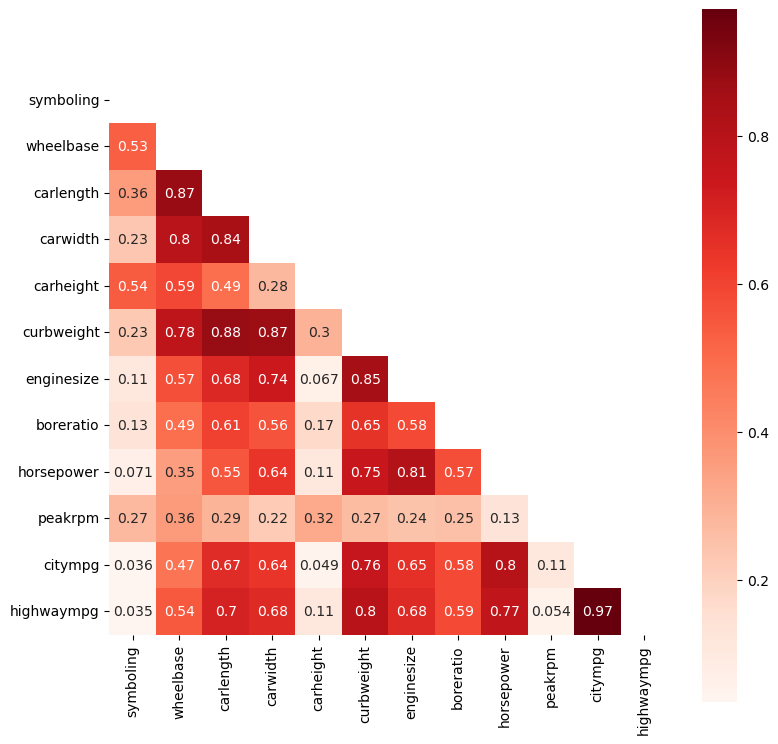

In [129]:
plt.figure(figsize = (9, 9))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = 'True', cmap = 'Reds', annot = True, mask = mask)

**Interpretation:**

carlength and wheelbase, carwidth and wheelbase, carwidth and carlength, curbweight and carlength, curbweight and carwidth, enginesize and curbweight, horsepower and enginesize, citympg and horsepower, and highwaympg and citympg all have correlations > 0.8. 

/var/folders/8k/75t3_8pj0v32jr8dhb7x00nw0000gn/T/ipykernel_65617/3407926620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().abs()


<AxesSubplot: >

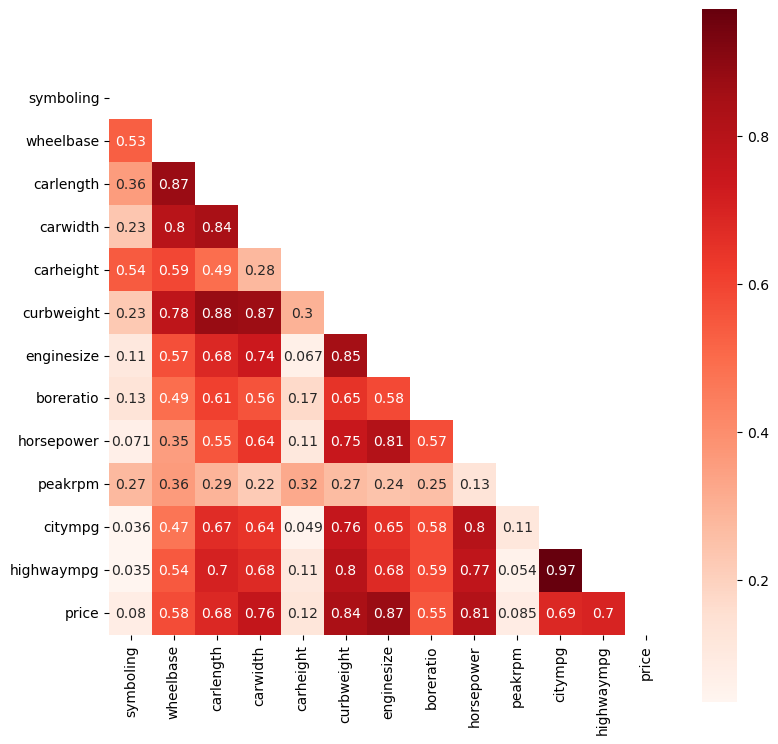

In [130]:
# adding corr heatmap with price
corr = df.corr().abs()
plt.figure(figsize = (9, 9))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = 'True', cmap = 'Reds', annot = True, mask = mask)

In [131]:
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [132]:
corr

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,horsepower,peakrpm,citympg,highwaympg,price
symboling,1.000000,0.531954,0.357612,0.232919,0.541038,0.227691,0.105790,0.130051,0.070873,0.273606,0.035823,0.034606,0.079978
wheelbase,0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.353294,0.360469,0.470414,0.544082,0.577816
carlength,0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.552623,0.287242,0.670909,0.704662,0.682920
carwidth,0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.640732,0.220012,0.642704,0.677218,0.759325
carheight,0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,0.108802,0.320411,0.048640,0.107358,0.119336
curbweight,0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.750739,0.266243,0.757414,0.797465,0.835305
enginesize,0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.809769,0.244660,0.653658,0.677470,0.874145
boreratio,0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,0.573677,0.254976,0.584532,0.587012,0.553173
horsepower,0.070873,0.353294,0.552623,0.640732,0.108802,0.750739,0.809769,0.573677,1.000000,0.131073,0.801456,0.770544,0.808139
peakrpm,0.273606,0.360469,0.287242,0.220012,0.320411,0.266243,0.244660,0.254976,0.131073,1.000000,0.113544,0.054275,0.085267


In [133]:
corr['price']#['wheelbase']

symboling     0.079978
wheelbase     0.577816
carlength     0.682920
carwidth      0.759325
carheight     0.119336
curbweight    0.835305
enginesize    0.874145
boreratio     0.553173
horsepower    0.808139
peakrpm       0.085267
citympg       0.685751
highwaympg    0.697599
price         1.000000
Name: price, dtype: float64

In [134]:
corr.index

Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'horsepower', 'peakrpm',
       'citympg', 'highwaympg', 'price'],
      dtype='object')

In [135]:
corr.loc['symboling', 'symboling']

1.0

In [136]:
tup = ('symboling', 'wheelbase')
tup[0]

'symboling'

In [137]:
# defining function to find and drop highly correlated features

def drop_multicollinearity(target, data = df, thresh = 0.80):
    high_corr = []
    drop_cols = []
    corr = data.drop(columns = target).corr(numeric_only = True).abs()
    mask = np.triu(np.ones_like(corr))
    # make a list of tuples for column and index pairs with values greater than the threshold
    for i, col in enumerate(corr.columns):
        for j, index in enumerate(corr.index):
            if (corr.loc[index, col] > thresh) and (mask[j, i] == 0):
                high_corr.append((index, col))
    
    # Find which feature has higher correlation to the target
    target_corr = data.corr().abs()[target]
    for tup in high_corr:
        if target_corr[tup[0]] > target_corr[tup[1]]:
            drop_cols.append(tup[1])
        else:
            drop_cols.append(tup[0])
    unique_np = np.unique(np.array(drop_cols))
    
    ans = input('Do you want to drop the multicollinear features [y/n]: ')
    if ans == 'y':
        for col in unique_np:
            print(f'Dropping {col}')
        data = data.drop(columns = unique_np)
    
    return data
        
    

In [138]:
df_dropped = drop_multicollinearity(target = 'price', data = df, thresh = 0.80)
df_dropped





/var/folders/8k/75t3_8pj0v32jr8dhb7x00nw0000gn/T/ipykernel_65617/992607895.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  target_corr = data.corr().abs()[target]


Do you want to drop the multicollinear features [y/n]: y
Dropping carlength
Dropping carwidth
Dropping citympg
Dropping curbweight
Dropping horsepower
Dropping wheelbase


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,peakrpm,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,48.8,dohc,four,130,mpfi,3.47,5000,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,48.8,dohc,four,130,mpfi,3.47,5000,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,52.4,ohcv,six,152,mpfi,2.68,5000,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,54.3,ohc,four,109,mpfi,3.19,5500,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,54.3,ohc,five,136,mpfi,3.19,5500,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,55.5,ohc,four,141,mpfi,3.78,5400,28,16845.0
201,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,55.5,ohc,four,141,mpfi,3.78,5300,25,19045.0
202,-1,volvo 244dl,gas,std,four,sedan,rwd,front,55.5,ohcv,six,173,mpfi,3.58,5500,23,21485.0
203,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,55.5,ohc,six,145,idi,3.01,4800,27,22470.0


/var/folders/8k/75t3_8pj0v32jr8dhb7x00nw0000gn/T/ipykernel_65617/774450979.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_dropped.corr().abs()


<AxesSubplot: >

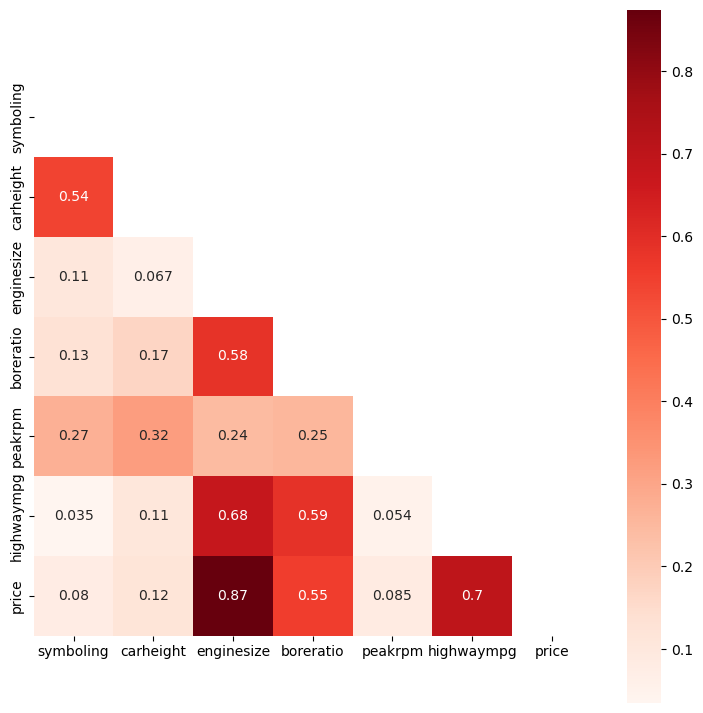

In [139]:
# adding corr heatmap with price
corr = df_dropped.corr().abs()
plt.figure(figsize = (9, 9))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = 'True', cmap = 'Reds', annot = True, mask = mask)

## Running the Model

In [140]:
# make X and y
y = df_dropped['price'].copy()
X = df_dropped.drop(columns = 'price').copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,peakrpm,highwaympg
90,1,nissan gt-r,diesel,std,two,sedan,fwd,front,54.5,ohc,four,103,idi,2.99,4800,50
173,-1,toyota corolla,gas,std,four,sedan,fwd,front,54.9,ohc,four,122,mpfi,3.31,4200,34
93,1,nissan titan,gas,std,four,wagon,fwd,front,53.5,ohc,four,97,2bbl,3.15,5200,37
5,2,audi fox,gas,std,two,sedan,fwd,front,53.1,ohc,five,136,mpfi,3.19,5500,25
167,2,toyota corona liftback,gas,std,two,hardtop,rwd,front,52.0,ohc,four,146,mpfi,3.62,4800,30


In [141]:
# make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include = 'object')
cat_cols = cat_select(X_train)
cat_cols

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [142]:
# make num selector and using it to save list of column names
num_selector = make_column_selector(dtype_include = 'number')
num_cols = num_selector(X_train)

# Make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'missing'), 
                        OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

preprocessor = make_column_transformer((num_pipe, num_cols), (cat_pipe, cat_cols),
                                      remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['symboling', 'carheight', 'enginesize',
                                  'boreratio', 'peakrpm', 'highwaympg']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['CarName', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem'])])

In [143]:
preprocessor.fit(X_train)
cat_features = preprocessor.named_transformers_['pipeline-2'][-1]#.get_feature_names_out(cat_cols)
cat_features




OneHotEncoder(handle_unknown='ignore', sparse=False)

In [144]:
# Convert preprocessed dataframes back into dataframes
preprocessor.fit(X_train)
# create list of our final features
final_features = []
final_features.extend(num_cols)
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
final_features.extend(cat_features)

## transform X vars and remake as dataframe

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = final_features,
                         index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = final_features,
                         index = X_test.index)
X_test_df.head()


,symboling,carheight,enginesize,boreratio,peakrpm,highwaympg,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,...,cylindernumber_six,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
15,0.0,55.7,209.0,3.62,5400.0,22.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,52.0,131.0,3.13,5500.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100,0.0,54.7,120.0,3.33,5200.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
132,3.0,56.1,121.0,3.54,5250.0,28.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,58.7,183.0,3.58,4350.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [145]:
# adding constants for statsmodel
X_train_df = sm.add_constant(X_train_df, prepend = False)
X_test_df = sm.add_constant(X_test_df, prepend = False)
display(X_train_df.head(), X_test_df.head())




,symboling,carheight,enginesize,boreratio,peakrpm,highwaympg,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,const
90,1.0,54.5,103.0,2.99,4800.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
173,-1.0,54.9,122.0,3.31,4200.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
93,1.0,53.5,97.0,3.15,5200.0,37.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.0,53.1,136.0,3.19,5500.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
167,2.0,52.0,146.0,3.62,4800.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


,symboling,carheight,enginesize,boreratio,peakrpm,highwaympg,CarName_Nissan versa,CarName_alfa-romero Quadrifoglio,CarName_alfa-romero giulia,CarName_alfa-romero stelvio,...,cylindernumber_six,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
15,0.0,55.7,209.0,3.62,5400.0,22.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,52.0,131.0,3.13,5500.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100,0.0,54.7,120.0,3.33,5200.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
132,3.0,56.1,121.0,3.54,5250.0,28.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,58.7,183.0,3.58,4350.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [146]:
# Fitting the Regression Model
model = sm.OLS(y_train, X_train_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     25.27
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           2.56e-08
Time:                        15:40:17   Log-Likelihood:                -1167.4
No. Observations:                 153   AIC:                             2613.
Df Residuals:                      14   BIC:                             3034.
Df Model:                         138                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [147]:
# statsmodels saves the residuals inside the model results under the 'resid' attribute
resid = result.resid
resid.head()

90    -8.049028e-09
173   -1.415533e+03
93    -8.236384e-09
5     -1.097214e-08
167   -5.311449e-09
dtype: float64

## Assumption of Normality with Q-Q plots

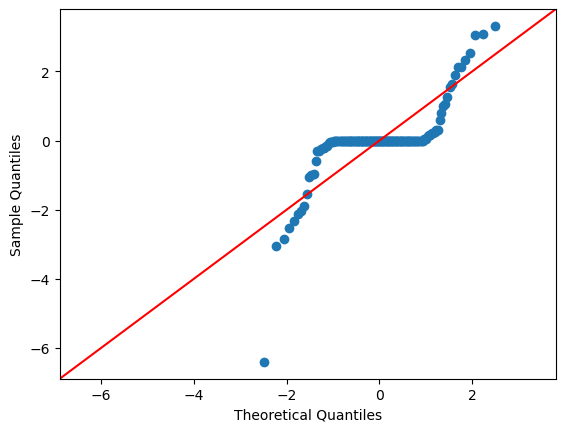

In [148]:
sm.graphics.qqplot(resid, line = '45', fit = True);

In [149]:
X_train_df.shape

(153, 162)

## Assumption of Homoscedasticity

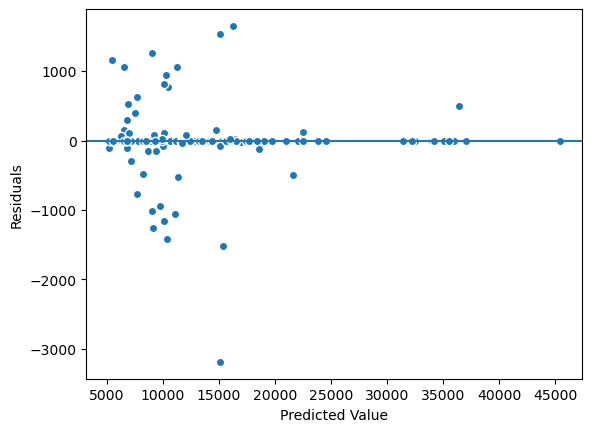

In [150]:
# residual plot: prediction of X-axis, residuals on the y-axis
# Get predictions and calculate residuals
y_pred = result.predict(X_train_df)
resid = y_train - y_pred
## plot predictions vs. resids
fig, ax = plt.subplots()
ax.scatter(y_pred, resid, ec = 'white', lw = 1)
ax.axhline(0)
ax.set(ylabel = 'Residuals', xlabel = 'Predicted Value');

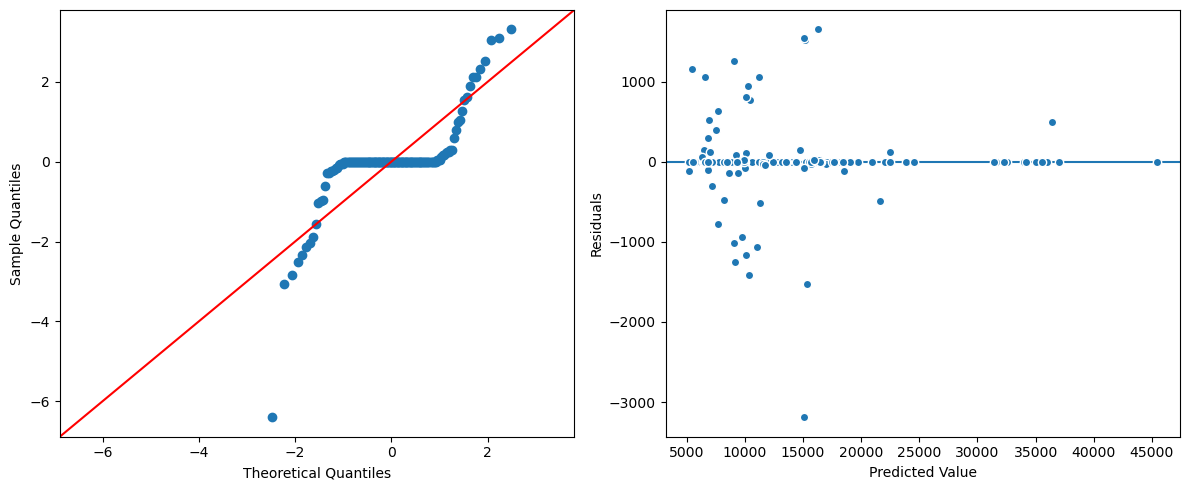

In [151]:
def evaluate_ols(result, X_train_df, y_train):
    
    # save residals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols = 2, figsize = (12, 5))
    
    # Normality
    sm.graphics.qqplot(resid, line = '45', fit = True, ax = axes[0]);
    
    # Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor = 'white', lw = 1)
    ax.axhline(0, zorder = 0)
    ax.set(ylabel = 'Residuals', xlabel = 'Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result, X_train_df, y_train)
    

**Interpretation:**

QQplot shows some non-linear characteristics, however, it never strays too far from the expected line if the data was completely normal.

There are a few large residuals shown in the residual plot mostly at the smaller predicted values. Does not look as Homoscedastic as we may want. 

## Diagnosing the Model

In [152]:
# scaling target
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))
z_price

array([[-0.7956461 ],
       [-0.56095133],
       [-0.76391344],
       [ 0.23896561],
       [-0.62428972],
       [-0.19323324],
       [ 3.00326125],
       [-1.01269751],
       [-0.5247761 ],
       [ 0.48635344],
       [-0.26901084],
       [ 0.39800971],
       [-0.3388227 ],
       [-0.82661718],
       [ 0.96500891],
       [-0.77076769],
       [ 1.09803223],
       [-0.38362922],
       [-0.81608193],
       [ 0.60706449],
       [-0.73167305],
       [-0.92308447],
       [ 0.4223804 ],
       [-0.48606225],
       [-0.05360953],
       [-0.07658398],
       [-0.85022628],
       [-0.6867396 ],
       [-0.73091147],
       [ 0.66672189],
       [ 0.44141999],
       [ 0.60706449],
       [ 0.39762892],
       [-0.91115299],
       [-0.29439697],
       [-0.73091147],
       [ 2.62246931],
       [-0.80960847],
       [-1.04709571],
       [-0.77076769],
       [ 0.47061404],
       [-0.35189655],
       [-0.88729003],
       [ 0.27196758],
       [ 0.06062805],
       [-0

In [153]:
# need to use the indices of our outliers to remove them across X and y
# need to convert back to Series with the same index that it originally had 
z_price = pd.Series(z_price.flatten(), index = y_train.index)
z_price.head()


90    -0.795646
173   -0.560951
93    -0.763913
5      0.238966
167   -0.624290
dtype: float64

In [154]:
# Saving the true/false result as our outlier index
idx_outliers = abs(z_price) > 3
idx_outliers.head()

90     False
173    False
93     False
5      False
167    False
dtype: bool

In [155]:
idx_outliers.sum()

2

In [156]:
# save a cleaned version of y_train and X_train with outliers removed
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]


In [157]:
# What value of price were removed from our analysis
print(f"Our model includes car prices:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes car prices:
- Greater than $5,118.00
- Less than $36,880.00


In [158]:
# Getting scaled y_test
z_price_test = scaler.transform(y_test.values.reshape(-1,1))
z_price_test = pd.Series(z_price_test.flatten(),index=y_test.index )
# saving the true/false result as our outlier index
idx_outliers_test= z_price_test>3
# how many outleirs in test data?
idx_outliers_test.sum()

2

In [159]:
## make clean version of X_test and y_test
X_test_cln = X_test_df[~idx_outliers_test] 
y_test_cln = y_test[~idx_outliers_test]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     21.28
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           8.12e-08
Time:                        15:40:19   Log-Likelihood:                -1153.1
No. Observations:                 151   AIC:                             2580.
Df Residuals:                      14   BIC:                             2994.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

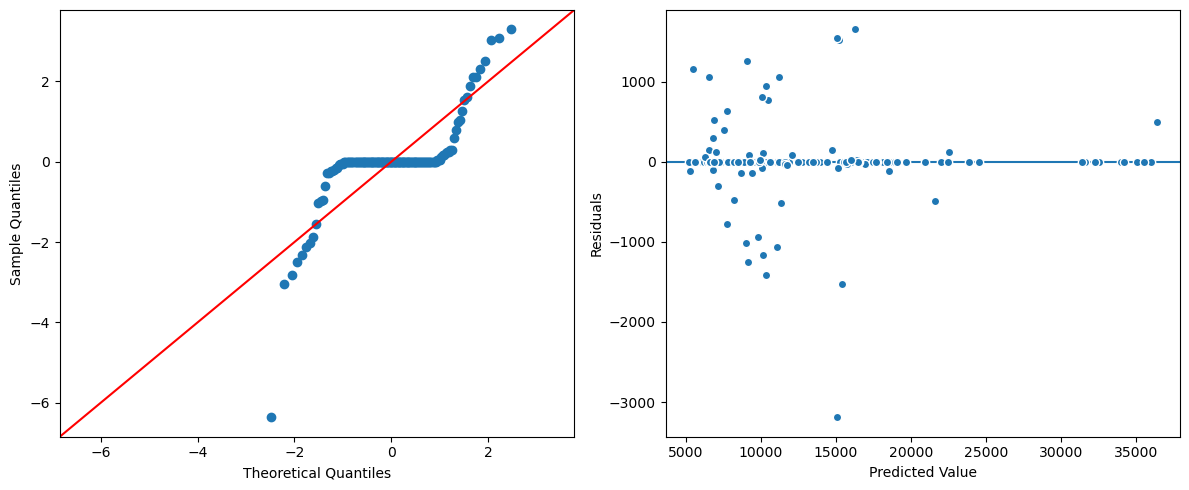

In [160]:
## make and fit a statsmodels OLS
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

**Interpretation:**

No real change to the model or plots. We will still say that this is acceptable for model interpretations.

## Remove Columns with insignificant P-values

In [161]:
# save p-value
p_vals = result.pvalues
# filter for p_value that are >0.05
for pval in p_vals[p_vals>0.05].index:
    print(pval)

symboling
carheight
boreratio
highwaympg
CarName_Nissan versa
CarName_alfa-romero Quadrifoglio
CarName_alfa-romero giulia
CarName_alfa-romero stelvio
CarName_audi 100 ls
CarName_audi 4000
CarName_audi 5000
CarName_buick opel isuzu deluxe
CarName_buick skylark
CarName_chevrolet vega 2300
CarName_dodge challenger se
CarName_dodge colt (sw)
CarName_dodge coronet custom
CarName_dodge d200
CarName_dodge dart custom
CarName_dodge rampage
CarName_honda accord
CarName_honda accord cvcc
CarName_honda accord lx
CarName_honda civic
CarName_honda civic (auto)
CarName_honda civic 1500 gl
CarName_honda civic cvcc
CarName_honda prelude
CarName_isuzu D-Max 
CarName_isuzu MU-X
CarName_jaguar xf
CarName_jaguar xj
CarName_jaguar xk
CarName_maxda glc deluxe
CarName_maxda rx3
CarName_mazda 626
CarName_mazda glc
CarName_mazda glc 4
CarName_mazda glc custom
CarName_mazda glc deluxe
CarName_mazda rx-4
CarName_mazda rx-7 gs
CarName_mazda rx2 coupe
CarName_mercury cougar
CarName_mitsubishi g4
CarName_mitsubishi

In [162]:
check_list = ['CarName', 'fueltype', 'aspiration', 
              'doornumber', 'carbody', 'drivewheel', 
              'enginelocation', 'enginetype', 'cylindernumber',
              'fuelsystem']

for feature in check_list:
    col_list = [col for col in X_train_cln.columns if col.startswith(feature)]
    p_list = [p for p in p_vals[p_vals>0.05].index if p.startswith(feature)]
    if ((len(p_list)/len(col_list)) > 0.5):
        for col in col_list:
            print(f'Dropping {col}')
        X_train_cln = X_train_cln.drop(columns = col_list)
        X_test_cln = X_test_cln.drop(columns = col_list)

    

Dropping CarName_Nissan versa
Dropping CarName_alfa-romero Quadrifoglio
Dropping CarName_alfa-romero giulia
Dropping CarName_alfa-romero stelvio
Dropping CarName_audi 100 ls
Dropping CarName_audi 100ls
Dropping CarName_audi 4000
Dropping CarName_audi 5000
Dropping CarName_audi fox
Dropping CarName_bmw 320i
Dropping CarName_bmw x1
Dropping CarName_bmw x3
Dropping CarName_bmw z4
Dropping CarName_buick opel isuzu deluxe
Dropping CarName_buick regal sport coupe (turbo)
Dropping CarName_buick skyhawk
Dropping CarName_buick skylark
Dropping CarName_chevrolet vega 2300
Dropping CarName_dodge challenger se
Dropping CarName_dodge colt (sw)
Dropping CarName_dodge coronet custom
Dropping CarName_dodge d200
Dropping CarName_dodge dart custom
Dropping CarName_dodge rampage
Dropping CarName_honda accord
Dropping CarName_honda accord cvcc
Dropping CarName_honda accord lx
Dropping CarName_honda civic
Dropping CarName_honda civic (auto)
Dropping CarName_honda civic 1500 gl
Dropping CarName_honda civic 

In [163]:
print(X_train_cln.head())
X_train_cln = X_train_cln.drop(columns = ['symboling', 'carheight', 'boreratio', 'highwaympg'])
print(X_train_cln.head())

     symboling  carheight  enginesize  boreratio  peakrpm  highwaympg  const
90         1.0       54.5       103.0       2.99   4800.0        50.0    1.0
173       -1.0       54.9       122.0       3.31   4200.0        34.0    1.0
93         1.0       53.5        97.0       3.15   5200.0        37.0    1.0
5          2.0       53.1       136.0       3.19   5500.0        25.0    1.0
167        2.0       52.0       146.0       3.62   4800.0        30.0    1.0
     enginesize  peakrpm  const
90        103.0   4800.0    1.0
173       122.0   4200.0    1.0
93         97.0   5200.0    1.0
5         136.0   5500.0    1.0
167       146.0   4800.0    1.0


In [164]:
X_test_cln = sm.add_constant(X_test_cln, prepend = False)
display(X_test_cln.head())
X_test_cln = X_test_cln.drop(columns = ['symboling', 'carheight', 'boreratio', 'highwaympg'])
dislay(X_test_cln.head())

,symboling,carheight,enginesize,boreratio,peakrpm,highwaympg,const
15,0.0,55.7,209.0,3.62,5400.0,22.0,1.0
9,0.0,52.0,131.0,3.13,5500.0,22.0,1.0
100,0.0,54.7,120.0,3.33,5200.0,34.0,1.0
132,3.0,56.1,121.0,3.54,5250.0,28.0,1.0
68,-1.0,58.7,183.0,3.58,4350.0,25.0,1.0


     enginesize  peakrpm  const
15        209.0   5400.0    1.0
9         131.0   5500.0    1.0
100       120.0   5200.0    1.0
132       121.0   5250.0    1.0
68        183.0   4350.0    1.0


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     218.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           6.48e-45
Time:                        15:43:07   Log-Likelihood:                -1452.2
No. Observations:                 151   AIC:                             2910.
Df Residuals:                     148   BIC:                             2919.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
enginesize   167.7751      8.042     20.863      0.0

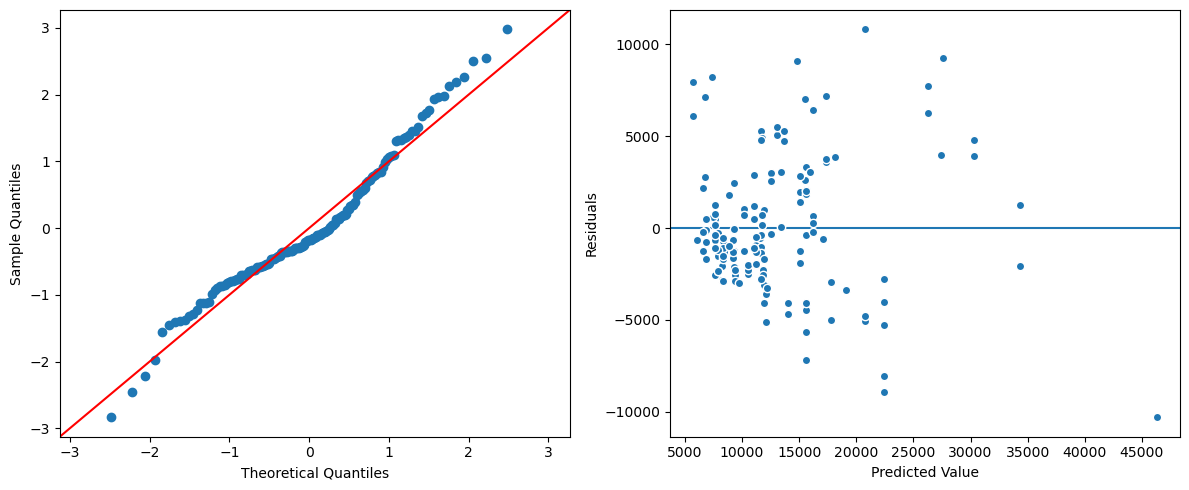

In [165]:
## make and fit a statsmodels OLS
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

**Interpretation:**

Removing the non-significant terms greatly improved the normality of the data (QQplot) and the spread of the residual plot 

R-Squared for Test Data: 0.71


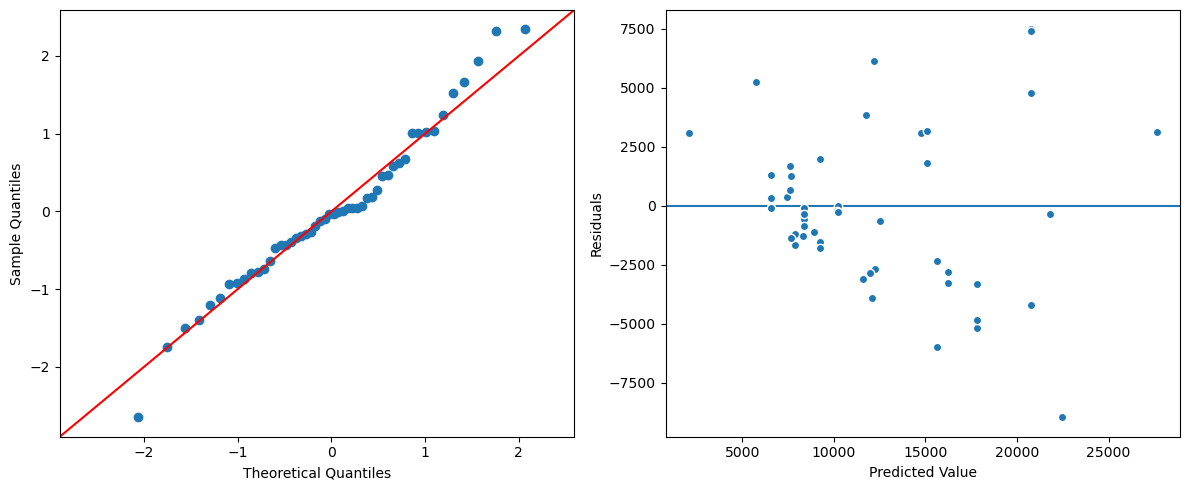

In [166]:
## evaluate test
r2_test = r2_score(y_test_cln, result.predict(X_test_cln))
print(f"R-Squared for Test Data: {r2_test:.2f}")
evaluate_ols(result, X_test_cln, y_test_cln)

**Interpretation:**

Overall, removing non-significant features reduced the r-squared of the model. However, there is no longer overfitting evident by how close in value the train and test r-squared values are.

**Summary:**

- The data had several features that did not have a linear relation to the target, these features were dropped. 
- Many features had strong multicollinearity with one another. Of the collinear features, the ones that shared the strongest correlation to the target were kept. The rest of the features were dropped. 
- The data had some outliers in the residuals that were dropped from both the train and test sets
- Many features in the OLS model did not have significant p-values, such columns were dropped from the train and test datasets.
- The final model only contained enginesize and peakrpm as features.


The model scores performed worse after dropping so many features, however, the model did perform equivalently between the train and test data. The QQplot and residuals plot also fit the assumptions of linear regression much better after cleaning the data.